In [25]:
import json
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob


target_llm = "Magpie-Align/Llama-3-8B-Magpie-Align-SFT-v0.2"
adversary_llm = "Magpie-Align/Llama-3-8B-Tulu-330K"

In [26]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

battle_data = load_jsonl("arena-hard/data/arena_hard_battles.jsonl")
question_data = load_jsonl("arena-hard/data/arena-hard-v0.1/question.jsonl")

In [27]:
battle_df = pd.DataFrame(battle_data)
battle_df_req = battle_df['model_b'].isin([target_llm , adversary_llm])
battle_df = battle_df[battle_df_req]

# count the number of battles for each model 
battle_df['model_b'].value_counts()
battle_df[battle_df['winner'] == 'model_b']['model_b'].value_counts()


model_b
Magpie-Align/Llama-3-8B-Magpie-Align-SFT-v0.2    266
Magpie-Align/Llama-3-8B-Tulu-330K                 68
Name: count, dtype: int64

In [28]:
# now what are the question_ids for the battle that each model won 
model_b_wins = battle_df[battle_df['winner'] == 'model_b']
qn_id_target_llm = model_b_wins[model_b_wins["model_b"] == target_llm]['question_id'].values
qn_id_adversary_llm = model_b_wins[model_b_wins["model_b"] == adversary_llm]['question_id'].values

# are there any questions that both models won?
common_qn_ids = np.intersect1d(qn_id_target_llm, qn_id_adversary_llm) # 25 questions
len(common_qn_ids)

# remove the common questions from the target_llm and adversary_llm wins
qn_id_target_llm = np.setdiff1d(qn_id_target_llm, common_qn_ids)
qn_id_adversary_llm = np.setdiff1d(qn_id_adversary_llm, common_qn_ids)


In [45]:
question_df = pd.json_normalize(question_data, 'turns', ['question_id', 'category', 'cluster'])
question_df.columns = ['content', 'question_id', 'category', 'cluster']

# get the question data for the questions that the target_llm won
question_df_req = question_df['question_id'].isin(qn_id_target_llm)
question_df_target_llm = question_df[question_df_req]

# get the question data for the questions that the adversary_llm won
question_df_req = question_df['question_id'].isin(qn_id_adversary_llm)
question_df_adversary_llm = question_df[question_df_req]

question_df_target_llm = question_df_target_llm.drop(columns=['category'])
question_df_target_llm.rename(columns={'content': 'question_content'}, inplace=True)
question_df_target_llm.head(5)

,question_content,question_id,cluster
1,SOLVE THIS IN C++ : There are three cards with...,b43c07656ead4150b360294ee932b410,ABC Sequence Puzzles & Groups
4,I have a dataset which contains a list of 2D i...,04ba0aeb79524f6c8520d47cada34f25,AI Image Upscaling
6,if you were a corporate law with 15 years of m...,ed3077a3443a4cf88233f5bc636e7394,AI Startup Business Strategies
7,Describe how to incorporate AI in the private ...,90b29911b57848ec89fc7d8c15f27c88,AI Startup Business Strategies
8,how does memory affect performance of aws lamb...,f54e99e9686549e7a096dd16dbab28e1,AWS Cloud Services Essentials


In [47]:
target_llm_answer = load_jsonl("arena-hard/data/arena-hard-v0.1/model_answer/Llama-3-8B-Magpie-Align-SFT-v0.2.jsonl")
adversary_llm_answer = load_jsonl("arena-hard/data/arena-hard-v0.1/model_answer/Llama-3-8B-Tulu-330K.jsonl")

# Function to load, normalize, and process LLM answer data
def process_llm_answers(llm_answer, qn_id_list, content_col_name):
    df = pd.json_normalize(llm_answer, 
                           record_path=['choices', 'turns'], 
                           meta=['question_id', 'answer_id', 'model_id', 'tstamp', ['choices', 'index']],
                           errors='ignore')

    df.columns = ['content', 'token_len', 'question_id', 'answer_id', 'model_id', 'tstamp', 'choice_index']
    df = df[df['question_id'].isin(qn_id_list)]
    df.rename(columns={'content': content_col_name}, inplace=True)
    df = df.drop(columns=['model_id', 'tstamp', 'choice_index'])
    return df

target_llm_answer_df = process_llm_answers(target_llm_answer, qn_id_target_llm, 'target_answer_content')
adversary_llm_answer_df = process_llm_answers(adversary_llm_answer, qn_id_target_llm, 'adversary_answer_content')
adversary_llm_answer_df.head(5)

,adversary_answer_content,token_len,question_id,answer_id
0,To implement a SCIM server in PHP using Slim a...,2048,0122ab60646b4961bc39e9c03bdf6bcc,o76FxBoXK9HbEeVaTHvXqW
1,The likely cause of the issue is that the chat...,208,01b5156495464638b98e1f8d9be12c23,cnTMDSo6YTSBphpjbFuSCb
6,"The error message ""sshd[54785]: error: kex_exc...",244,037edf47ede9428b9ef91c737d6f7a9c,jddjEJXmCZ7QKe3tu87BNZ
8,"from flask import Flask, request, abort\nfrom ...",316,0394b670ad2e4206954cc294898c4633,Edc8pyHXYRBMCiBqvUmzpq
9,To find the closest image in a dataset of 2D i...,223,04ba0aeb79524f6c8520d47cada34f25,UU2MWBrvR8p3Si5NUcMLhf


## Investigating responses that the target llm won and the adversay llm failed

In [31]:
# merge the question and answer data for the target_llm
target_llm_df = pd.merge(question_df_target_llm, target_llm_answer_df, on='question_id')

# merge the data of the target_llm with the adversary_llm answer data to compare the answers
df = pd.merge(target_llm_df, adversary_llm_answer_df[['question_id', 'answer_id', 'adversary_answer_content', 'token_len']], on=['question_id'])

df.rename(columns={'answer_id_x': 'target_answer_id','token_len_x': 'target_token_len', 
                   'answer_id_y': 'adversary_answer_id', 'token_len_y': 'adversary_token_len'}, inplace=True)

# Reorder columns for the final DataFrame
final_order = ['question_id', 'question_content', 'target_answer_id', 'target_answer_content', 
                'target_token_len', 'adversary_answer_id', 'adversary_answer_content', 'adversary_token_len', 'cluster']
df = df[final_order]
df.head(5)

,question_id,question_content,target_answer_id,target_answer_content,target_token_len,adversary_answer_id,adversary_answer_content,adversary_token_len,cluster
0,b43c07656ead4150b360294ee932b410,SOLVE THIS IN C++ : There are three cards with...,XKAuaj7NoAxBrQUjjFX9ks,Here is a C++ solution for the problem:\n\n```...,271,7AZMidDYPzWCCfFq6KxmJ5,#include <bits/stdc++.h>\nusing namespace std;...,179,ABC Sequence Puzzles & Groups
1,04ba0aeb79524f6c8520d47cada34f25,I have a dataset which contains a list of 2D i...,dTDWEuECnjqpMCCecpnubk,A classic problem!\n\nThis is known as the **N...,576,UU2MWBrvR8p3Si5NUcMLhf,To find the closest image in a dataset of 2D i...,223,AI Image Upscaling
2,ed3077a3443a4cf88233f5bc636e7394,if you were a corporate law with 15 years of m...,CRVoDx64etuK4XDpcy7TEn,What a fascinating question! As a corporate la...,829,TvybKcQKLS9Gm7hm5AytRb,As a corporate lawyer with 15 years of mergers...,452,AI Startup Business Strategies
3,90b29911b57848ec89fc7d8c15f27c88,Describe how to incorporate AI in the private ...,MwjHVuSSp5XCSiF3ysF972,Incorporating AI in the private equity deal so...,782,UrYqsYpjatUT5mdkzT2BnA,Incorporating AI in the private equity deal so...,264,AI Startup Business Strategies
4,f54e99e9686549e7a096dd16dbab28e1,how does memory affect performance of aws lamb...,HLvN3kuNVUXsZcj9vT9zWE,"In AWS Lambda, memory allocation plays a cruci...",606,Ey4gQUUzjcpmfUVEntGVm5,Memory usage is a critical factor in the perfo...,264,AWS Cloud Services Essentials


In [36]:
def clean_answer_content(text):
    text = re.sub(r'\n+', ' ', text)  # Replace newlines with space
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.strip()

# Clean the content columns
# df['target_answer_content'] = df['target_answer_content'].apply(clean_answer_content)
# df['adversary_answer_content'] = df['adversary_answer_content'].apply(clean_answer_content)

# Token Length Comparison
df['token_len_difference'] = df['target_token_len'] - df['adversary_token_len']

# Word Count Comparison
def count_words(text):
    return Counter(text.split())

df['target_word_count'] = df['target_answer_content'].apply(count_words)
df['adversary_word_count'] = df['adversary_answer_content'].apply(count_words)

df.to_csv("target_vs_adversary.csv")
df.head(5)


,question_id,question_content,target_answer_id,target_answer_content,target_token_len,adversary_answer_id,adversary_answer_content,adversary_token_len,cluster,token_len_difference,target_word_count,adversary_word_count,target_sentiment,target_subjectivity,adversary_sentiment,adversary_subjectivity
0,b43c07656ead4150b360294ee932b410,SOLVE THIS IN C++ : There are three cards with...,XKAuaj7NoAxBrQUjjFX9ks,Here is a C++ solution for the problem:\n\n```...,271,7AZMidDYPzWCCfFq6KxmJ5,#include <bits/stdc++.h>\nusing namespace std;...,179,ABC Sequence Puzzles & Groups,92,"{'Here': 1, 'is': 5, 'a': 3, 'C++': 1, 'soluti...","{'#include': 1, '<bits/stdc++.h>': 1, 'using':...",0.064583,0.650000,0.166667,0.333333
1,04ba0aeb79524f6c8520d47cada34f25,I have a dataset which contains a list of 2D i...,dTDWEuECnjqpMCCecpnubk,A classic problem!\n\nThis is known as the **N...,576,UU2MWBrvR8p3Si5NUcMLhf,To find the closest image in a dataset of 2D i...,223,AI Image Upscaling,353,"{'A': 1, 'classic': 1, 'problem!': 1, 'This': ...","{'To': 2, 'find': 3, 'the': 17, 'closest': 6, ...",-0.069705,0.514703,-0.133333,0.366667
2,ed3077a3443a4cf88233f5bc636e7394,if you were a corporate law with 15 years of m...,CRVoDx64etuK4XDpcy7TEn,What a fascinating question! As a corporate la...,829,TvybKcQKLS9Gm7hm5AytRb,As a corporate lawyer with 15 years of mergers...,452,AI Startup Business Strategies,377,"{'What': 1, 'a': 31, 'fascinating': 1, 'questi...","{'As': 2, 'a': 11, 'corporate': 2, 'lawyer': 2...",0.142836,0.477388,0.137085,0.518326
3,90b29911b57848ec89fc7d8c15f27c88,Describe how to incorporate AI in the private ...,MwjHVuSSp5XCSiF3ysF972,Incorporating AI in the private equity deal so...,782,UrYqsYpjatUT5mdkzT2BnA,Incorporating AI in the private equity deal so...,264,AI Startup Business Strategies,518,"{'Incorporating': 1, 'AI': 22, 'in': 7, 'the':...","{'Incorporating': 1, 'AI': 7, 'in': 3, 'the': ...",0.075016,0.519825,0.108794,0.496352
4,f54e99e9686549e7a096dd16dbab28e1,how does memory affect performance of aws lamb...,HLvN3kuNVUXsZcj9vT9zWE,"In AWS Lambda, memory allocation plays a cruci...",606,Ey4gQUUzjcpmfUVEntGVm5,Memory usage is a critical factor in the perfo...,264,AWS Cloud Services Essentials,342,"{'In': 2, 'AWS': 3, 'Lambda,': 2, 'memory': 27...","{'Memory': 1, 'usage': 2, 'is': 7, 'a': 8, 'cr...",0.158490,0.507564,0.133354,0.565017


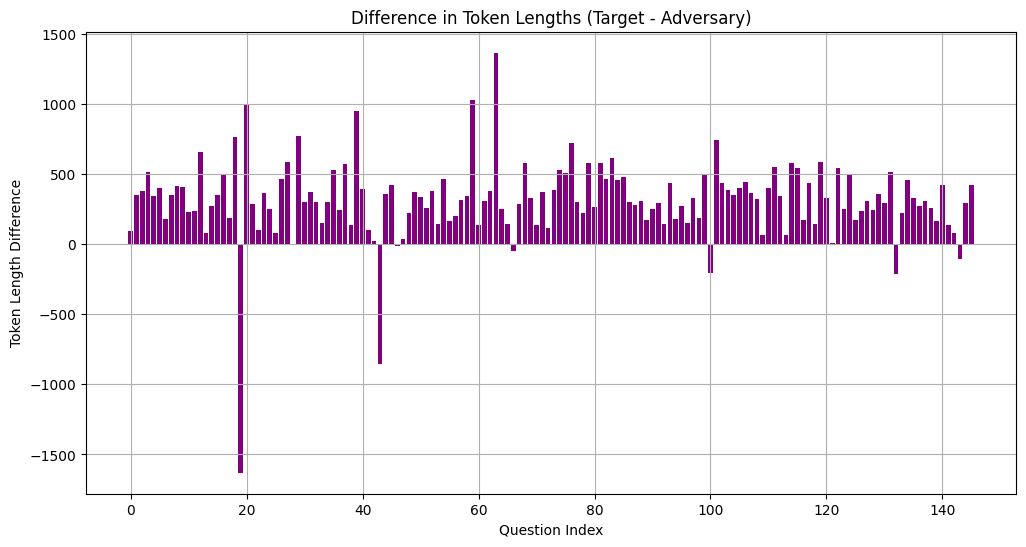

In [33]:
# Bar chart for the difference in token lengths
plt.figure(figsize=(12, 6))
plt.bar(df.index, df['token_len_difference'], color='purple')
plt.title('Difference in Token Lengths (Target - Adversary)')
plt.xlabel('Question Index')
plt.ylabel('Token Length Difference')
plt.grid(True)
plt.show()

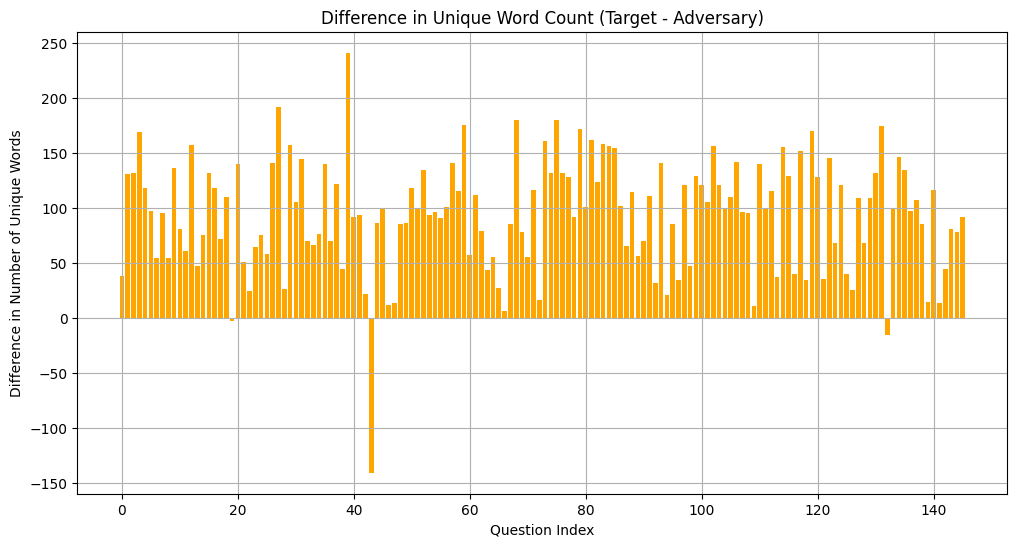

In [34]:
unique_word_count_diff = df['target_word_count'].apply(lambda x: len(x)) - df['adversary_word_count'].apply(lambda x: len(x))

# Bar plot of the differences in unique word counts
plt.figure(figsize=(12, 6))
plt.bar(df.index, unique_word_count_diff, color='orange')
plt.title('Difference in Unique Word Count (Target - Adversary)')
plt.xlabel('Question Index')
plt.ylabel('Difference in Number of Unique Words')
plt.grid(True)
plt.show()

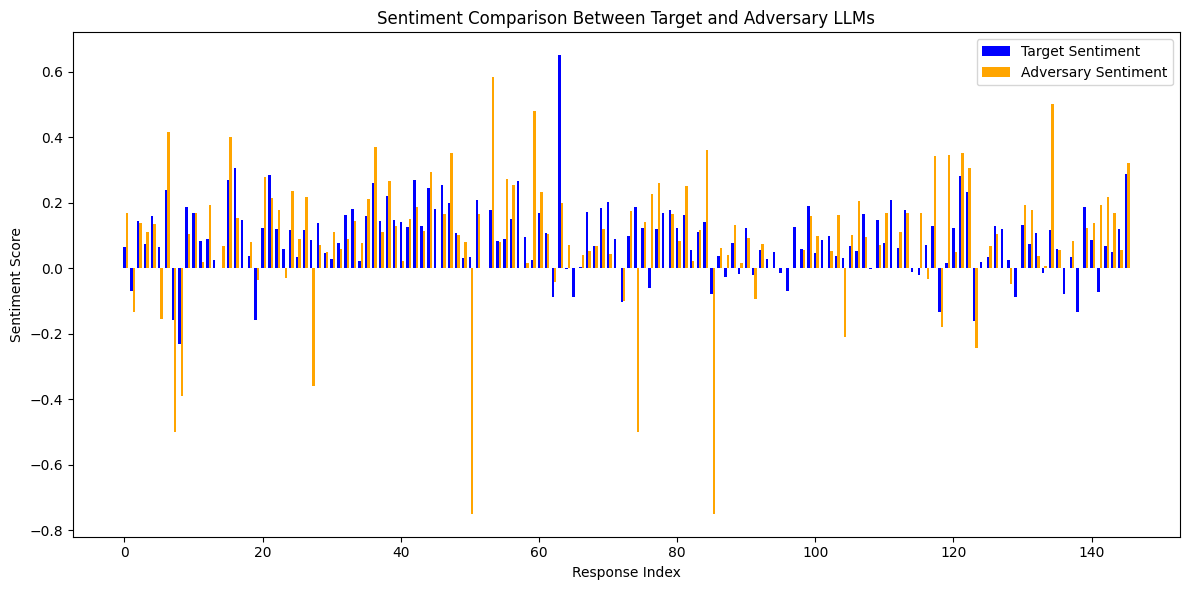

In [44]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis to both target and adversary responses
df['target_sentiment'], df['target_subjectivity'] = zip(*df['target_answer_content'].apply(analyze_sentiment))
df['adversary_sentiment'], df['adversary_subjectivity'] = zip(*df['adversary_answer_content'].apply(analyze_sentiment))

N = len(df)
index = np.arange(N)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(index, df['target_sentiment'], bar_width, label='Target Sentiment', color='blue')
bars2 = ax.bar(index + bar_width, df['adversary_sentiment'], bar_width, label='Adversary Sentiment', color='orange')

ax.set_xlabel('Response Index')
ax.set_ylabel('Sentiment Score')
ax.set_title('Sentiment Comparison Between Target and Adversary LLMs')
ax.legend()

plt.tight_layout()
plt.show()

## Investigating responses that the adversay llm won and the target llm failed

In [56]:
target_llm_answer_df_2 = process_llm_answers(target_llm_answer, qn_id_adversary_llm, 'target_answer_content')
adversary_llm_answer_df_2 = process_llm_answers(adversary_llm_answer, qn_id_adversary_llm, 'adversary_answer_content')

In [68]:
# merge the question and answer data for the adversary_llm
adversary_llm_df = pd.merge(question_df_adversary_llm, adversary_llm_answer_df_2, on='question_id')
adversary_llm_df.drop(columns=['category'], inplace=True)
adversary_llm_df.rename(columns={'content': 'adversary_question_content'}, inplace=True)

# merge the data of the adversary_llm with the target_llm answer data to compare the answers
check = pd.merge(adversary_llm_df, target_llm_answer_df_2[['question_id', 'answer_id', 'target_answer_content', 'token_len']], on=['question_id'])

check.rename(columns={'answer_id_x': 'adversary_answer_id','token_len_x': 'adversary_token_len', 
                   'answer_id_y': 'target_answer_id', 'token_len_y': 'target_token_len'}, inplace=True)

# Reorder columns for the final DataFrame
final_order = ['question_id', 'adversary_question_content', 'adversary_answer_id', 'adversary_answer_content', 
                'adversary_token_len', 'target_answer_id', 'target_answer_content', 'target_token_len', 'cluster']
check = check[final_order]

# Token Length Comparison
check['token_len_difference'] = check['adversary_token_len'] - check['target_token_len']

check.to_csv("adversary_vs_target.csv")
check.head(5)



,question_id,adversary_question_content,adversary_answer_id,adversary_answer_content,adversary_token_len,target_answer_id,target_answer_content,target_token_len,cluster,token_len_difference
0,46e73778f43143199f88b2e354df85eb,How can I generate a seaborn barplot that incl...,SnXEPPVub68RSv4TxeK27F,To generate a seaborn barplot that includes th...,168,USetAg42NMwgckjNyq8Twq,You can use the `seaborn` library in combinati...,553,Advanced Matplotlib Customizations,-385
1,3971e3d0eb194b8c9344030bebd0c6aa,Here are the top issues reported for a Schedul...,dNju4RtgwKyZ6R3pEeFud2,| Category | Count |\n| --- | --- |\n| Loadboa...,86,8BSdAvToWa2wGvZDYbeYGU,Here is the categorization of the issues repor...,403,Batch Size in Deep Learning,-317
2,4a0cf903c61b47ceb49166b591c703d5,Give me example of blocking read interrupted b...,SKCac2Gycb7deYEYqjDow9,Here is an example of a blocking read function...,457,Bs6akVe3k4xi2jwsfwmktN,Here is an example of a blocking read that is ...,549,"Concurrency, Sockets, and Webhooks",-92
3,4e5a75c6a5fb492ab529fc41d1d669ea,What is the 95% confidence interval for the su...,k7LShkvxodkRaHn8VLCw3e,To find the 95% confidence interval for the su...,359,LwgUgYLutyp2iqo8dCuauj,A classic problem!\n\nThe sum of 100 fair six-...,405,Dice Probability Calculations,-46
4,6225fbb8f3084d57852db56882e972ba,"During the current year, Sue Shells, Incorpora...",76zyYaSJBG7CuxY7wdSPnH,"To determine the change in Sue Shells, Incorpo...",182,WaQNimfuqtMf3Tne5jZ4cK,Let's analyze the situation:\n\n* Total liabil...,165,Dionne's Business Accounting,17


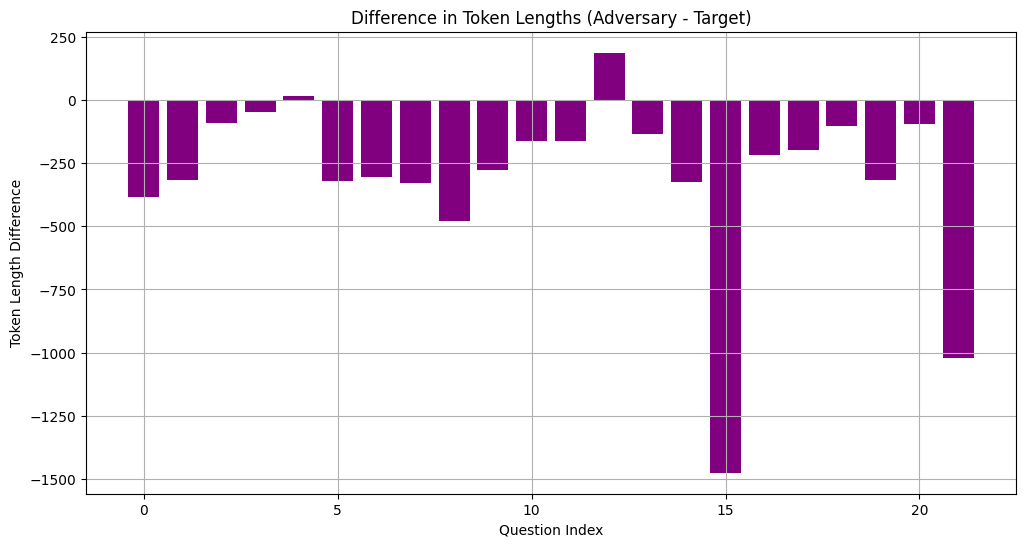

In [66]:
# Bar chart for the difference in token lengths
plt.figure(figsize=(12, 6))
plt.bar(check.index, check['token_len_difference'], color='purple')
plt.title('Difference in Token Lengths (Adversary - Target)')
plt.xlabel('Question Index')
plt.ylabel('Token Length Difference')
plt.grid(True)
plt.show()

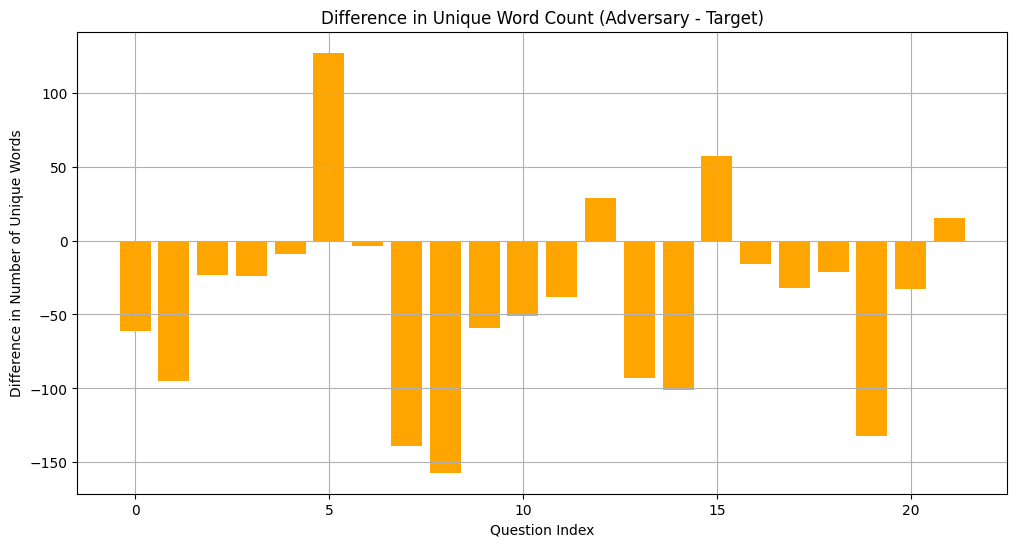

In [67]:
# Word Count Comparison
check['target_word_count'] = check['target_answer_content'].apply(count_words)
check['adversary_word_count'] = check['adversary_answer_content'].apply(count_words)

unique_word_count_diff = check['adversary_word_count'].apply(lambda x: len(x)) - check['target_word_count'].apply(lambda x: len(x))

# Bar plot of the differences in unique word counts
plt.figure(figsize=(12, 6))
plt.bar(check.index, unique_word_count_diff, color='orange')
plt.title('Difference in Unique Word Count (Adversary - Target)')
plt.xlabel('Question Index')
plt.ylabel('Difference in Number of Unique Words')
plt.grid(True)
plt.show()